# The Vector Method for Detecting Temperature Inversions in Skew-T Log-P Upper Air Charts

### Developed by Per Lundquist, M.S. Graduate Student, South Dakota Mines Atmospheric and Environmental Sciences

In this jupyter notebook, a method for detecting and parsing out major temperature inversions of interest within an upper air sounding is presented. 

First, upper air data is ingested from the University of Wyoming's Atmospheric Soundings website and a Skew-T Log-P chart is built from scratch. 

Next, data is scanned from the surface upward until the first point at which the temperature increases with height is detected. This point is saved as the starting point of the temperature inversion. Upward scanning continues until a point in which the temperature returns to decreasing with height is detected. The point preceding this point is saved as the ending point of the temperature inversion. A line is drawn between these two points and labeled as an "inversion vector." Scanning continues until all inversion vectors are grabbed. 

Lastly, the temperature and height axes of the Skew-T Log-P chart are scaled to a similar range. The distance of the inversion vectors in the scaled Temperature-Pressure space is ranked and the inversion vector with the largest distance is parsed out and labelled as the primary inversion of interest. In a subsequent notebook, the primary inversions between the High Resolution Rapid Refresh (HRRR) Numerical Weather Prediction (NWP) model and observed data are compared. This notbook will simply present a method for parsing out the primary inversion.

**Methods presented are adapted from the followign papers**

Kahl, J. D., 1990: Characteristics of the low-level cloud temperature inversion along the Alaskan Arctic coast. *International Journal of Climatology*, **10**, 537-548. https://doi.org/10.1002/joc.3370100509

Serreze, M. C., Kahl, J. D., & Schnell, R. C., 1992: Low-Level Temperature Inversions of the Eurasian Arctic and Comparisons with Soviet Drifting Station Data. *Journal of Climate*, **5**(6), 615-629. [https://doi.org/10.1175/1520-0442(1992)005<0615:LLTIOT>2.0.CO;2](https://doi.org/10.1175/1520-0442(1992)005<0615:LLTIOT>2.0.CO;2)

-------------------------------

## Imports

While most of these libraries are rather standard, you'll want to take note on the toolbox.cartopy_tools libary. This was a tool developed by Brian Blaylock during his Ph.D work at the University of Utah. In order to install the toolbox, I simply downloaded the modules and dropped the folder into my python envirnoment. Dr. Blaylock also provided installation instructions on his GitHub

This environment for me was at the following local address: C: \ Users \ {username} \ .conda \ envs \ {envname} \ Lib \

[Click here to access the library files](https://github.com/blaylockbk/Carpenter_Workshop)

Citation: Blaylock, B. K. (2022). Carpenter Workshop (Version 2022.11.0) [Computer software]. https://github.com/blaylockbk/Carpenter_Workshop

In [1]:
# Imports

import math                                                  # A math library from the Standar Python Libraries
import numpy as np                                           # Numerical Python is a common number handling tool used in python
import pandas as pd                                          # A popular data analytics tool in python developed by Wes McKinney. Here it is used to handle array objects such as upper air soundings
pd.set_option('display.min_rows', 30)                        # Changing the default number of rows in a dataframe that pandas will display

from datetime import datetime                                # A module from the standard python library for handling date objects. Will be used to import data at specific times, but is also handy in iterating through dates
from siphon.simplewebservice.wyoming import WyomingUpperAir  # Siphon is a tool developed by Unidata for querying data from various THREDDS servers. This particular module accesses data from the THREDDS server owned by the University of Wyoming

import matplotlib.pyplot as plt                              # Matplotlib is a popular charting tool used in python. The pyplot module in particular creates images and charts
from toolbox.cartopy_tools import common_features            # includes a skew-T projection for matplotlib. Comes from Brian Blaylock's Carpenter Workshop project

## Let's get some data ingested and displayed

For this example, we'll grab some observed sounding data from the University of Wyoming's Atmospheric Soundings archive. This data will be from the Rapid City National Weather Service Upper Air site (KUNR) from 2017-01-24 at 12UTC

In [2]:
# Grab the Sounding Data


#### INITITALIZE THE DATE AND TIME ####

# First we need to set the date to a datetime object. Siphon ingests datetime objects to query the server, but other 
# libraries you might run into could use strings, so be careful with that!

date = datetime(2017, 1, 24, 12) # year, month, day, hour

# Another option for setting the date that could be helpful

date_str = '2017-01-24 12:00'
date     = datetime.strptime(date_str, "%Y-%m-%d %H:%M") # include the date string and a string denoting the formatting 
                                                         # of the string. Now you have a datetime object!


#### DOWNLOAD THE DATA ####

station = 'RAP' # While we are grabbing from the KUNR site, University of Wyoming has it labelled as RAP, as the nearby
                # airport is KRAP
df = WyomingUpperAir.request_data(date, station) # df is a common name for generic pandas dataframes. Siphon will
                                                 # download the data and save it to a pandas dataframe

display(df) # simple display function to check our work. This comes from the iPython library which is automatically
            # imported every time you initialize a jupyter notebook, so no need to import it. THIS WILL ONLY WORK
            # IN A JUPYTER ENVIRONMENT!!! IF YOU'VE NEVER USED JUPYTER BEFORE, PLEASE LOOK UP TUTORIALS ON HOW TO DO SO!

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,890.0,1029,-7.5,-8.2,355.0,5.0,4.357787e-01,-4.980973,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
1,889.0,1038,-6.7,-7.4,355.0,5.0,4.357787e-01,-4.980973,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
2,887.0,1055,-6.5,-7.2,354.0,7.0,7.316992e-01,-6.961653,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
3,868.3,1219,-7.5,-8.4,345.0,16.0,4.141105e+00,-15.454813,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
4,850.0,1383,-8.5,-9.6,355.0,19.0,1.655959e+00,-18.927699,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
5,805.0,1803,-11.3,-12.2,360.0,21.0,5.143517e-15,-21.000000,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
6,802.3,1829,-10.7,-11.5,0.0,21.0,-0.000000e+00,-21.000000,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
7,796.0,1890,-9.3,-9.9,13.0,19.0,-4.274070e+00,-18.513031,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
8,787.0,1978,-8.9,-9.4,32.0,16.0,-8.478708e+00,-13.568770,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03
9,782.0,2027,-6.9,-7.6,42.0,14.0,-9.367828e+00,-10.404028,RAP,72662,2017-01-24 12:00:00,44.08,-103.21,1029.0,8.03


Let's now develop a block of code to plot this data into a Skew-T Log-P diagram. 

There is a particular library out there, [Meteorological Python, or MetPy](https://www.unidata.ucar.edu/software/metpy/), which can accomplish this goal for us. However, an issue with MetPy is that it heavily relies on attaching units to our values. This can make data processing such as scaling, plotting, and converting units rather convoluted, restricting us to the MetPy environment.

In order to remedy this, we will not import MetPy but rather we will build our own Skew-T Log-P chart from scratch, giving us full control

--------------------------------------------------

For those of you who are new to plotting in Matplotlib, there are some basics to understand, namely that the image produced is called the "figure" which can have multiple plots within them called "subplots" which in turn have multiple axes within them for which to plot data. You'll often see subplots referred to as "axes" referring to the multiple axes that can be displayed on each plot

![matplotlib.pyplot graph hierarchy](https://files.realpython.com/media/fig_map.bc8c7cabd823.png)

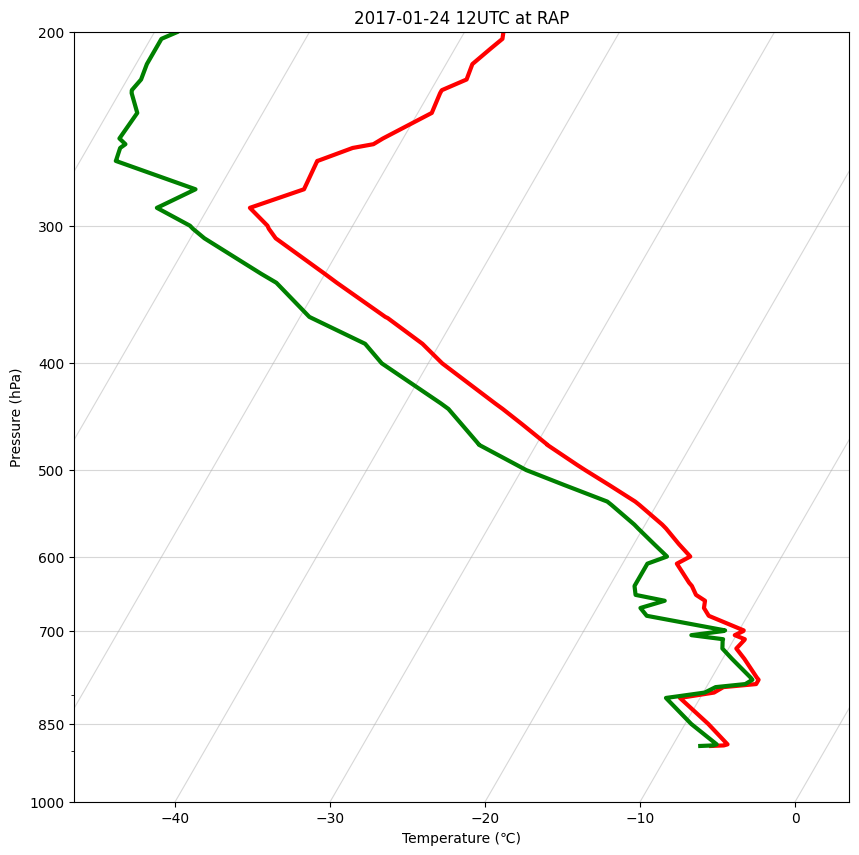

In [3]:
# plot a skew-T

# make a plot
# Change default to be better for skew-T
fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint'] # This line isn't crucial but it helps in labelling things

skew = plt.axes(projection='skewx', rotation=30)  # Takes the x-axis of the subplot and skews it by 30°. The skewx
                                                  # projection is part of Blaylock's toolbox (see imports). Since the 
                                                  # x axis is temperature/dewpoint in this scenario, we now have a 
                                                  # Skew-T plot! (now we just need that Log-P......)
        
                                                  # NOTE: We are labelling this plot 'skew' since it's a Skew-T in this
                                                  # scenario, but most often, you'll find people use 'ax' instead

        
# plot the data using logarithmic scale
# Since the y axix is pressure, we can use the .semilogy module to display it on a logarithmic scale
skew.semilogy(df['temperature'], df['pressure'], 'r', linewidth=3, alpha=1)
skew.semilogy(df['dewpoint'], df['pressure'], 'g', linewidth=3, alpha=1)



#### FORMATTING ####

# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC at ' + station)
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Pressure (hPa)')

# Set the y-axis label format to display y-values exactly as they are written in the pandas dataframe
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)


# Now lets set the bounds of our chart to make it legible. I've noticed that sometimes NaN values will trickle
# into the data, making it difficult to determine where our temperature bounds are. In this case, we'll put the
# axis limits in a try and except block. If we can't determine the maximum temperature in the dataset due to bad data,
# we'll just use a default domain
try:
    skew.set_xlim(np.max(df['temperature']) - 40, np.max(df['temperature']) + 10.)
    skew.set_ylim(1000, 200)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(1000, 200)


    
# These next two lines will make a predefined grid, setting tick marks at these exact values. This helps, especially on
# the temperature axis, as our skewed coordinate system makes it so we'd be missing some tick marks and the chart
# wouldn't look good. Comment out this code to see what I mean
skew.yaxis.set_major_locator(plt.FixedLocator([1000, 850, 700, 600, 500, 400, 300, 200]))

skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))

Now, you'll notice that the dataframe has readings recorded at various intervals, as shown in the pressure and height columns which do not have constant intervals between datapoints. As to not bias any portion of the sounding during data processing, we'll use a linear interpolation function to remake our dataframe such that points are plotted at a constant height interval

The function used to conduct a linear interpolation is as such:
$$x_y=x_{in data ABOVE}+\frac{(x_{in data BELOW} - x_{in data ABOVE})*(y_{above} - y)}{y_{above} - y_{below}}$$

Where x is the desired variable, and y is the height coordinate, which could be either height or pressure

Let's conduct a linear interpolation to regularly space our data at intervals of 100m, plotting a new Skew-T to ensure our data looks correct

In [4]:
# conduct a linear interpolation between points.

# ref_coord            = the desired location you want to conduct a linear interpolation. (y in the above equation)
# unfixed_data_coords  = array of the coordinate values in the raw data (contains y_above and y_below)
# unfixed_data_values  = array of the variable values from the raw data (contains x_above and x_below)
# increase_with_height = a boolean to tell the function if your height coordinate is increasing or decreasing with
#                        height. Used to switch between height and pressure coordinates
def linear_fix(ref_coord, unfixed_data_coords, unfixed_data_values, increase_with_height=False):
    
    # Rudimentary error checking. Doesn't stop the program, but won't create an interpolated dataframe
    if len(unfixed_data_coords) != len(unfixed_data_values):
        print('The variable and pressure arrays must be of equal length. Cancelling interpolation......')
        return
    
    # Height coordinates (function is the same in both scenarios)
    if increase_with_height:
        
        # scan the data until we find the first point above our reference point
        for i in range(len(unfixed_data_values)):
            if unfixed_data_coords[i] > ref_coord:
                # interpolate temp and rh between pressure levels above/below surface pressure to get surface values
                #
                # Equation: x = x_above + ( ((x_below - x_above) * (height_above - ref_height)) / (height_above - height_below) )

                fixed_value = unfixed_data_values[i] + (((unfixed_data_values[i - 1] - unfixed_data_values[i]) * (
                            unfixed_data_coords[i] - ref_coord)) / (unfixed_data_coords[i] - unfixed_data_coords[
                    i - 1]))
                return fixed_value
                break  # This won't run, but I put it here just in case. Perhaps I have anxiety, haha
    
    # Pressure coordinates
    else:
        
        # scan the data until we find the first point above our reference point
        for i in range(len(unfixed_data_values)):
            if unfixed_data_coords[i] < ref_coord:
                # interpolate temp and rh between pressure levels above/below surface pressure to get surface values
                #
                # Equation: x = x_above + ( ((x_below - x_above) * (pressure_above - ref_pressure)) / (pressure_above - pressure_below) )

                fixed_value = unfixed_data_values[i] + (((unfixed_data_values[i - 1] - unfixed_data_values[i]) * (
                            unfixed_data_coords[i] - ref_coord)) / (unfixed_data_coords[i] - unfixed_data_coords[
                    i - 1]))
                return fixed_value
                break  # just in case

In [5]:
# Make a new dataframe such that datapoints are every 100m
standard_heights = np.arange(0, 10000, 100)

# First adjust all heights in raw data to be height Above Ground Level (AGL)
sfc_height = df['height'][0]
df['height'] = df['height'] - sfc_height

# Make arrays for each variable we care about and conduct linear interpolation    
pressures = []
temps     = []
dwpts     = []

for h in standard_heights:
    pressures.append(linear_fix(h, df['height'], df['pressure'], increase_with_height=True))
    temps.append(linear_fix(h, df['height'], df['temperature'], increase_with_height=True))
    dwpts.append(linear_fix(h, df['height'], df['dewpoint'], increase_with_height=True))
    
df_standard = pd.DataFrame({
    'pressure': pressures,
    'height': standard_heights,
    'temperature': temps,
    'dewpoint': dwpts
})

display(df_standard)

,pressure,height,temperature,dewpoint
0,890.000000,0,-7.500000,-8.200000
1,878.562195,100,-6.951220,-7.741463
2,867.184146,200,-7.560976,-8.473171
3,856.025610,300,-8.170732,-9.204878
4,845.071429,400,-8.806667,-9.884762
5,834.357143,500,-9.473333,-10.503810
6,823.642857,600,-10.140000,-11.122857
7,812.928571,700,-10.806667,-11.741905
8,802.300000,800,-10.700000,-11.500000
9,792.011364,900,-9.122727,-9.678409


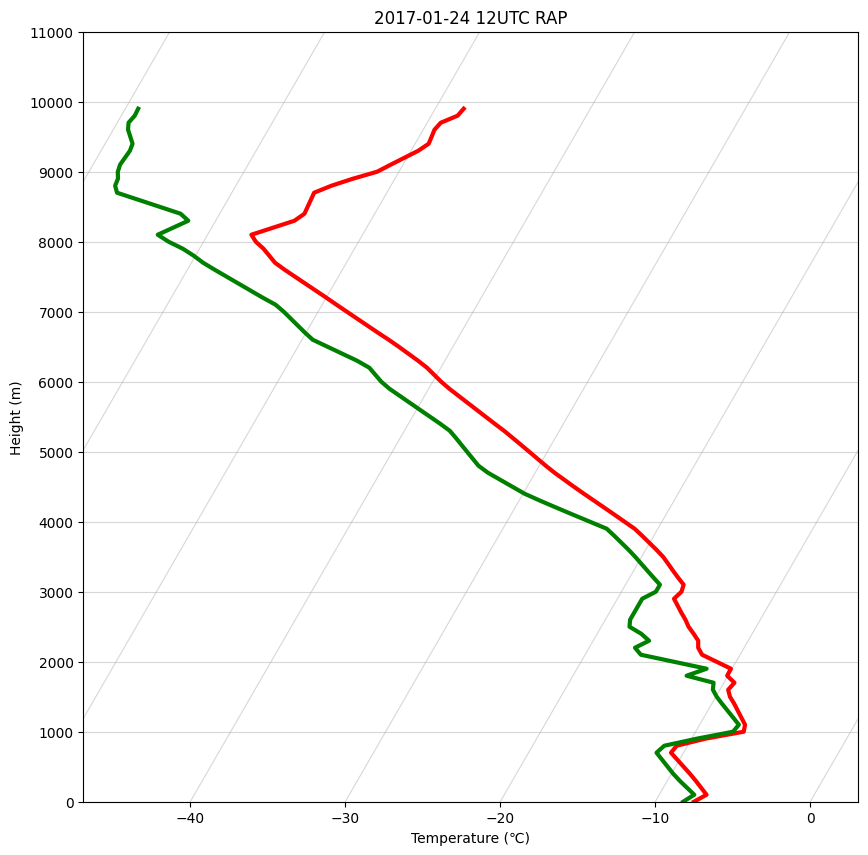

In [6]:
# plot a skew-T as we did before, but this time in height coorinates instead of pressure

# make a plot
fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)

# plot data using linear scale
skew.plot(df_standard['temperature'], df_standard['height'], 'r', linewidth=3, alpha=1)
skew.plot(df_standard['dewpoint'], df_standard['height'], 'g', linewidth=3, alpha=1)

# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC ' + station)
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Height (m)')

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

try:
    skew.set_xlim(np.max(df_standard['temperature']) - 40, np.max(df_standard['temperature']) + 10.)
    skew.set_ylim(0, 11000)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(0, 1100)

    # set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
                                               10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
                                               19000,
                                               20000]))
skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))

Awesome! That looks exactly like the raw Skew-T with the benefit of being at a constant height interval. Now we can reliably do data processing

----------------------------------------------

## Parse out the inversions

Now that we have data ingested, let's try to parse out all the temperature inversions. We'll be using an adapted version of the method presented in Kahl 1990, where we will scan the profile upward until we reach the first point at which the temperature lapse rate is positive, i.e. increasing with height. But to do this, we need lapse rates, so let's first attach lapse rate values to every point in our data

### Lapse rates

A finitie differencing method for determining lapse rates is used in which the rate of temperature change between the reference point and the next point above it is assigned as the lapse rate for said point, like so:

$$\Gamma_i=\frac{T_{i+1}-T_i}{H_{i+1}-H_i}$$

In [7]:
# set up all the lapse rates through finite differencing

# initialize a new lapse rate column that is full of zeros
df_standard['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value using the equation above
for i in range(len(df_standard['temperature'])):
    
    if i == ( len(df_standard['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        df_standard['lapse_rate'][i] = -9.7670 * (1/1000.)  # °C/m
    else:
        df_standard['lapse_rate'][i] = (df_standard['temperature'][i+1] - df_standard['temperature'][i]) / (df_standard['height'][i+1] - df_standard['height'][i])
        
display(df_standard)

C:\Users\perrl\AppData\Local\Temp\ipykernel_35816\587077208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standard['lapse_rate'][i] = (df_standard['temperature'][i+1] - df_standard['temperature'][i]) / (df_standard['height'][i+1] - df_standard['height'][i])


,pressure,height,temperature,dewpoint,lapse_rate
0,890.000000,0,-7.500000,-8.200000,0.005488
1,878.562195,100,-6.951220,-7.741463,-0.006098
2,867.184146,200,-7.560976,-8.473171,-0.006098
3,856.025610,300,-8.170732,-9.204878,-0.006359
4,845.071429,400,-8.806667,-9.884762,-0.006667
5,834.357143,500,-9.473333,-10.503810,-0.006667
6,823.642857,600,-10.140000,-11.122857,-0.006667
7,812.928571,700,-10.806667,-11.741905,0.001067
8,802.300000,800,-10.700000,-11.500000,0.015773
9,792.011364,900,-9.122727,-9.678409,0.022227


Now we catalogue the inversions by grabing their starting point, starting temp, ending point, and ending temp. We'll just put the inversion data in a simple list of coordinates for now

In [8]:
# We'll just use a list to save the inversions
inversions = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(df_standard['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( df_standard['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [df_standard['height'][i], df_standard['temperature'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( df_standard['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [df_standard['height'][i], df_standard['temperature'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        inversions.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0

    
display(inversions)

[[[0, -7.5], [100, -6.951219512195122]],
 [[700, -10.806666666666667], [1000, -6.9]],
 [[1600, -9.465217391304348], [1700, -9.320289855072465]],
 [[2900, -16.35049833887043], [3000, -16.128318584070797]],
 [[8100, -57.17307692307692], [8400, -54.533070866141735]],
 [[8700, -54.690551181102364], [9400, -49.12361623616236]],
 [[9600, -49.27121771217712], [9900, -48.17109004739336]]]

Now let's plot these

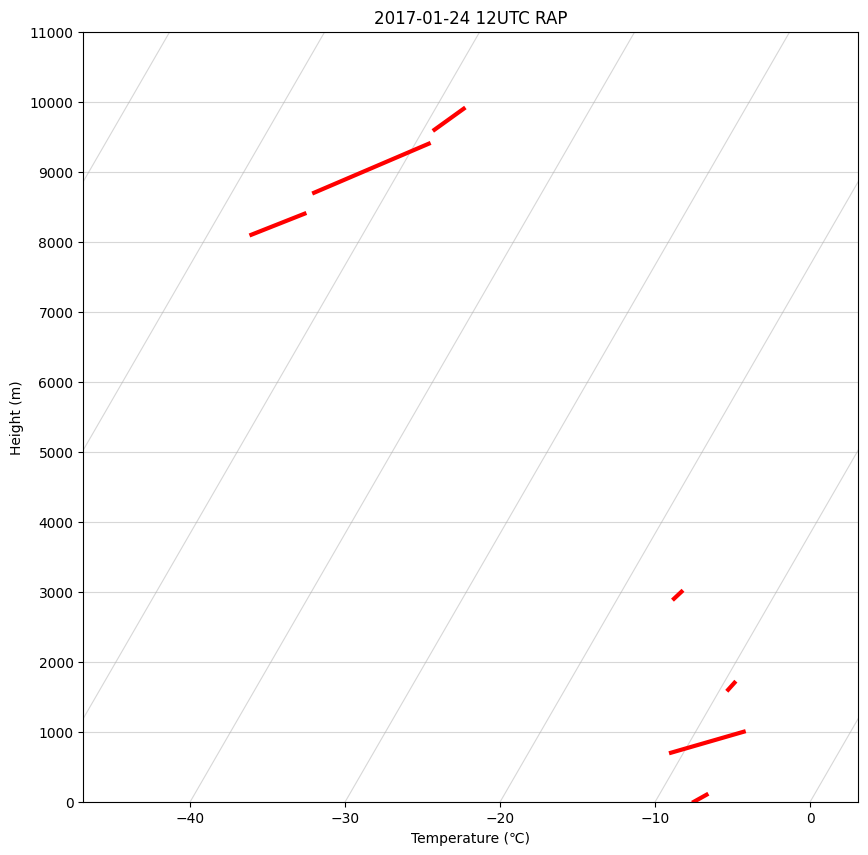

In [9]:
# Plot the inversion catalogue

fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)

# Iterate over each line segment
for line in inversions:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=3, alpha=1)


# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC ' + station)
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Height (m)')

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

try:
    skew.set_xlim(np.max(df_standard['temperature']) - 40, np.max(df_standard['temperature']) + 10.)
    skew.set_ylim(0, 11000)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(0, 1100)

    # set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
                                               10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
                                               19000,
                                               20000]))
skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))
plt.show()

## Checking our work thus far

Awesome! Now we have a bunch of simple inversion vectors which we can use to get depth, temperature range, and other characteristics about the inversions. 

Now, this next part is a bit of my own conjecture. When I'm determing a temperature inversion has any meteorological relavence, I typically look at which of these inversion vectors is the longest. I don't have a paper at the current that supports this habit of mine, but that's what I do. So the goal now is to remove all inversion vectors except for the largest one

Our first issue is that we can see just by looking at the chart, the temperature inversions detected in the stratosphere will be detected as being the primary inversions of interest, which for our purposes, is not what we want. As a quick fix, we'll remove the stratosphere entirely, restricting the data to the middle and lower troposphere by cutting off data above 5km. This was an abistrary cutoff point, but as shown in other jupyter notebooks with this project, it will actually make sense to decrease the cutoff height even further! For now, a 5km cutoff height is good for removing the stratosphere

In [10]:
# Make a new dataframe cutting off above 5km. (last point will have a fill value for lapse rate)
standard_heights = np.arange(0, 5000, 100)

# adjust all heights in raw data
sfc_height = df['height'][0]
df['height'] = df['height'] - sfc_height
    
pressures = []
temps     = []
dwpts     = []

for h in standard_heights:
    pressures.append(linear_fix(h, df['height'], df['pressure'], increase_with_height=True))
    temps.append(linear_fix(h, df['height'], df['temperature'], increase_with_height=True))
    dwpts.append(linear_fix(h, df['height'], df['dewpoint'], increase_with_height=True))
    
df_standard = pd.DataFrame({
    'pressure': pressures,
    'height': standard_heights,
    'temperature': temps,
    'dewpoint': dwpts
})

In [11]:
# set up all the lapse rates through finite differencing

# initialize a new lapse rate column that is full of zeros
df_standard['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value using the equation above
for i in range(len(df_standard['temperature'])):
    
    if i == ( len(df_standard['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        df_standard['lapse_rate'][i] = -9.7670 * (1/1000.)  # °C/m
    else:
        df_standard['lapse_rate'][i] = (df_standard['temperature'][i+1] - df_standard['temperature'][i]) / (df_standard['height'][i+1] - df_standard['height'][i])

C:\Users\perrl\AppData\Local\Temp\ipykernel_35816\4112328274.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standard['lapse_rate'][i] = (df_standard['temperature'][i+1] - df_standard['temperature'][i]) / (df_standard['height'][i+1] - df_standard['height'][i])


In [12]:
# We'll just use a list to save the inversions
inversions = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(df_standard['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( df_standard['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [df_standard['height'][i], df_standard['temperature'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( df_standard['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [df_standard['height'][i], df_standard['temperature'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        inversions.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0

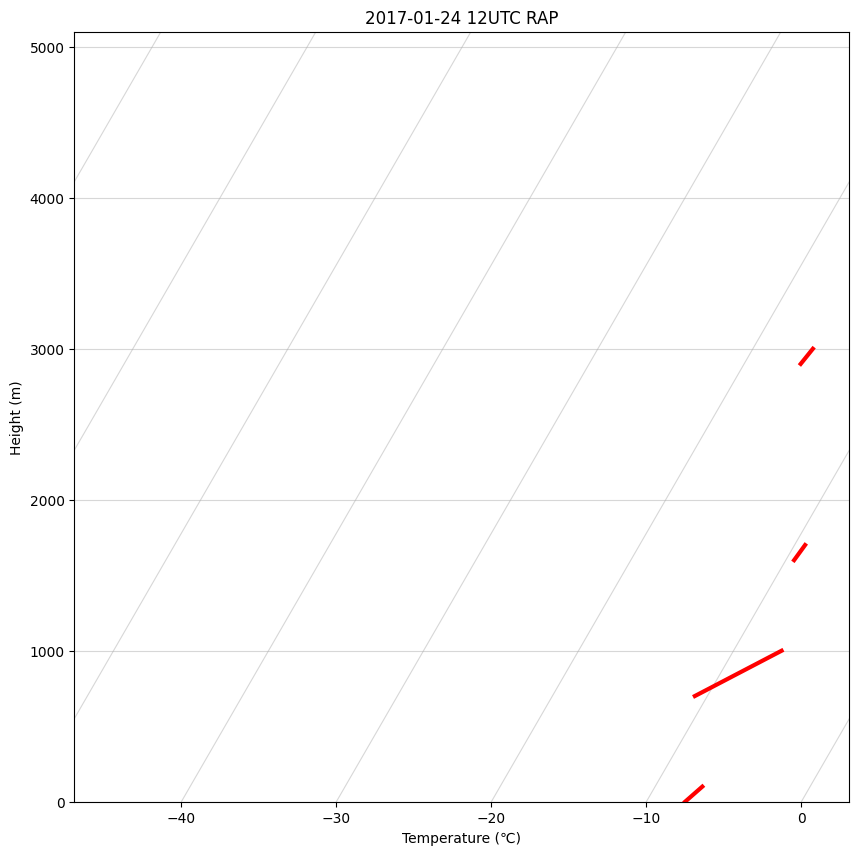

In [13]:
# Plot the inversion catalogue

fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)

# Iterate over each line segment
for line in inversions:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=3, alpha=1)


# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC ' + station)
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Height (m)')

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

try:
    skew.set_xlim(np.max(df_standard['temperature']) - 40, np.max(df_standard['temperature']) + 10.)
    skew.set_ylim(0, 5100)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(0, 5100)

    # set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
                                               10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
                                               19000,
                                               20000]))
skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))
plt.show()

Perfect! Now the inversion between 800m and 1000m AGL is obviously the inversion of interest. Now, how do we mathematecially determine that and parse it out?

---------------------

## Determining the distances of inversion vectors

Simply put, we'll need to use the distance formula to determine the lengths of these inversion vectors in height-temperaure space. We can then rank the inversion vectors by distance and parse out the largest one to be our inversion of interest

The distance formula is as follows:
$$d = \sqrt{(H_{upper} - H_{lower})^2 + (T_{upper} - T_{lower})^2}$$ 

In [14]:
# Calculate distances and store them with their respective line segments
data = [] # simple list to store the data of each inversion. Not organized quite yet

for line in inversions:
    point1, point2 = line
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

    # Extract relevant information
    start_height = point1[0]
    start_temp = point1[1]
    end_height = point2[0]
    end_temp = point2[1]
    
    # Save the data to the list
    data.append([distance, start_height, start_temp, end_height, end_temp])


# clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
inversion_ranks = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])
inversion_ranks = inversion_ranks.sort_values(by='Distance', ascending=False)
inversion_ranks = inversion_ranks.reset_index(drop=True)

display(inversion_ranks)

primary_inversion = inversion_ranks.head(1) # head is a pandas function that grabs the first few rows, the amount specified
display(primary_inversion)

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,300.025436,700,-10.806667,1000,-6.900000
1,100.001506,0,-7.500000,100,-6.951220
2,100.000247,2900,-16.350498,3000,-16.128319
3,100.000105,1600,-9.465217,1700,-9.320290


,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,300.025436,700,-10.806667,1000,-6.9


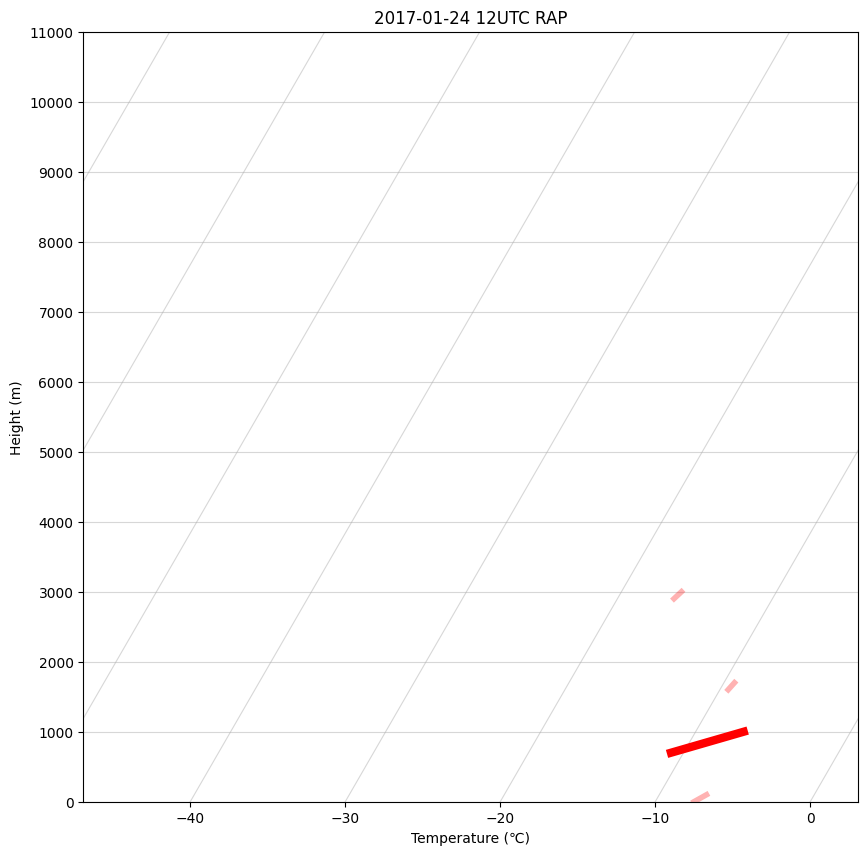

In [15]:
# Plot the inversions, highlighting the primary ivnersion

fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)


# Quickly make an inversion list using our organized data
inversions = []
for i in range(len(inversion_ranks)):
    inversions.append([[inversion_ranks['Starting Height'].iloc[i], inversion_ranks['Starting Temperature'].iloc[i]],
                       [inversion_ranks['Ending Height'].iloc[i], inversion_ranks['Ending Temperature'].iloc[i]]])

# Likewise the primary inversion
prime = []
for i in range(len(primary_inversion)):
    prime.append([[primary_inversion['Starting Height'].iloc[i], primary_inversion['Starting Temperature'].iloc[i]],
                  [primary_inversion['Ending Height'].iloc[i], primary_inversion['Ending Temperature'].iloc[i]]])

    
    
# Iterate over each line segment
for line in inversions:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=4, alpha=0.3) # We'll decrease the alpha channel of the inversions we
                                                               # don't care about so they don't stand out
        
# Plot the primary inversion
for line in prime:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=6, alpha=1)


# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC ' + station)
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Height (m)')

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

try:
    skew.set_xlim(np.max(df_standard['temperature']) - 40, np.max(df_standard['temperature']) + 10.)
    skew.set_ylim(0, 11000)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(0, 5100)

    # set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
                                               10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
                                               19000,
                                               20000]))
skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))
plt.show()

## The temperature inversion of interest was successfully parsed!

One thing to note is that the distance values in the inversion_ranks dataframe are in increments very close to 100. So too is our height coordinate. This is most likely due to the fact that the height coordinate is on the magnitude of thousands of meters while the temperature coordinate is on the magnitude of tens of degrees. They're of very different scale!

While in this example, the inversion was correctly parsed, what would happen in the scenario where there is a minor inversion over a large depth, and a major inversion over a shallow depth? Let's ingest new data and make some new plots to findo out

In [16]:
# Initialize a new date

date = datetime(2017, 10, 5, 12) # year, month, day, hour

station = 'RAP'
df = WyomingUpperAir.request_data(date, station)

In [17]:
# Make a new dataframe such that datapoints are every 100m
standard_heights = np.arange(0, 5000, 100)

# First adjust all heights in raw data to be height Above Ground Level (AGL)
sfc_height = df['height'][0]
df['height'] = df['height'] - sfc_height

# Make arrays for each variable we care about and conduct linear interpolation    
pressures = []
temps     = []
dwpts     = []

for h in standard_heights:
    pressures.append(linear_fix(h, df['height'], df['pressure'], increase_with_height=True))
    temps.append(linear_fix(h, df['height'], df['temperature'], increase_with_height=True))
    dwpts.append(linear_fix(h, df['height'], df['dewpoint'], increase_with_height=True))
    
df_standard = pd.DataFrame({
    'pressure': pressures,
    'height': standard_heights,
    'temperature': temps,
    'dewpoint': dwpts
})

In [18]:
# set up all the lapse rates through finite differencing

# initialize a new lapse rate column that is full of zeros
df_standard['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value using the equation above
for i in range(len(df_standard['temperature'])):
    
    if i == ( len(df_standard['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        df_standard['lapse_rate'][i] = -9.7670 * (1/1000.)  # °C/m
    else:
        df_standard['lapse_rate'][i] = (df_standard['temperature'][i+1] - df_standard['temperature'][i]) / (df_standard['height'][i+1] - df_standard['height'][i])

C:\Users\perrl\AppData\Local\Temp\ipykernel_35816\4112328274.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standard['lapse_rate'][i] = (df_standard['temperature'][i+1] - df_standard['temperature'][i]) / (df_standard['height'][i+1] - df_standard['height'][i])


In [19]:
# We'll just use a list to save the inversions
inversions = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(df_standard['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( df_standard['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [df_standard['height'][i], df_standard['temperature'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( df_standard['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [df_standard['height'][i], df_standard['temperature'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        inversions.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0

In [20]:
# Calculate distances and store them with their respective line segments
data = [] # simple list to store the data of each inversion. Not organized quite yet

for line in inversions:
    point1, point2 = line
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

    # Extract relevant information
    start_height = point1[0]
    start_temp = point1[1]
    end_height = point2[0]
    end_temp = point2[1]
    
    # Save the data to the list
    data.append([distance, start_height, start_temp, end_height, end_temp])


# clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
inversion_ranks = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])
inversion_ranks = inversion_ranks.sort_values(by='Distance', ascending=False)
inversion_ranks = inversion_ranks.reset_index(drop=True)

display(inversion_ranks)

primary_inversion = inversion_ranks.head(1) # head is a pandas function that grabs the first few rows, the amount specified
display(primary_inversion)

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,200.000509,300,9.755639,500,10.206897
1,100.098686,1100,5.954545,1200,10.398291
2,100.007675,0,9.600000,100,10.838938


,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,200.000509,300,9.755639,500,10.206897


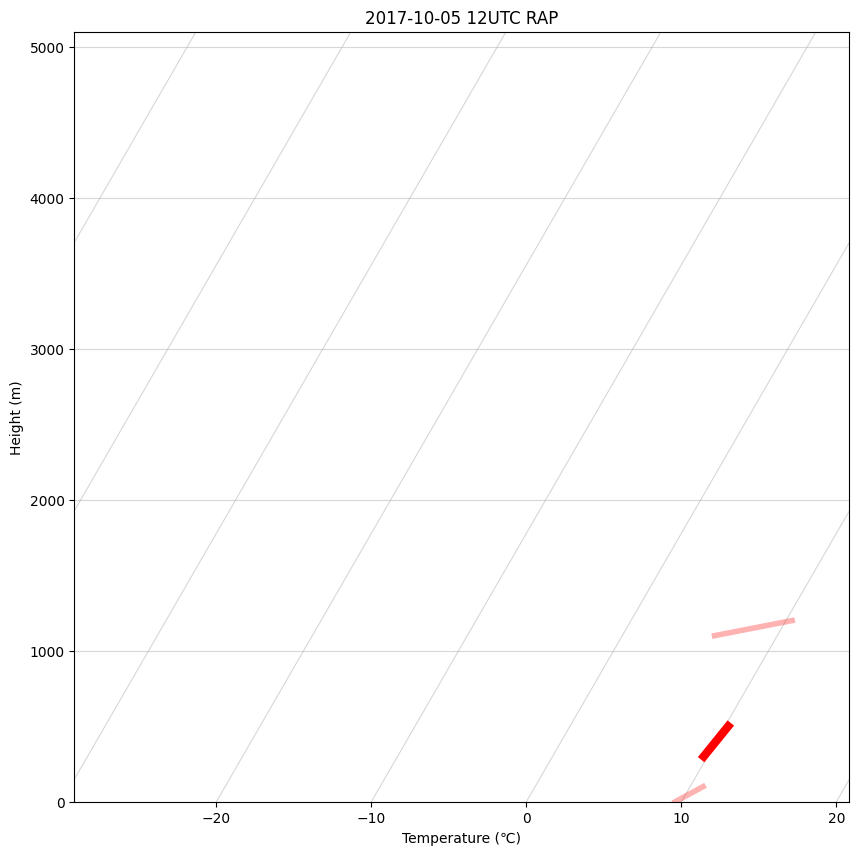

In [21]:
# Plot the inversions, highlighting the primary ivnersion

fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)


# Quickly make an inversion list using our organized data
inversions = []
for i in range(len(inversion_ranks)):
    inversions.append([[inversion_ranks['Starting Height'].iloc[i], inversion_ranks['Starting Temperature'].iloc[i]],
                       [inversion_ranks['Ending Height'].iloc[i], inversion_ranks['Ending Temperature'].iloc[i]]])

# Likewise the primary inversion
prime = []
for i in range(len(primary_inversion)):
    prime.append([[primary_inversion['Starting Height'].iloc[i], primary_inversion['Starting Temperature'].iloc[i]],
                  [primary_inversion['Ending Height'].iloc[i], primary_inversion['Ending Temperature'].iloc[i]]])

    
    
# Iterate over each line segment
for line in inversions:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=4, alpha=0.3) # We'll decrease the alpha channel of the inversions we
                                                               # don't care about so they don't stand out
        
# Plot the primary inversion
for line in prime:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=6, alpha=1)


# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC ' + station)
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Height (m)')

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

try:
    skew.set_xlim(np.max(df_standard['temperature']) - 40, np.max(df_standard['temperature']) + 10.)
    skew.set_ylim(0, 5100)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(0, 5100)

    # set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
                                               10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
                                               19000,
                                               20000]))
skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))
plt.show()

We see in this example that while there is an inversion starting at 300m AGL, while the code higlighted it as the inversion of interest, there is a stronger inversion starting at 1100m AGL. However, since the magnitude of the height coordinate is much greater than that of the temperature coordinate, making it hold more wieght in the vector distance calculation. With that, we will need to scale the coordinate system such that the axes are of similar magnitude

Now, when scaling data over a large dataset, what is done to one piece of data must be done to all others, and as a side note, this notebook is part of a larger project that looks at 6 years of sounding data from 4 different NWS offices. Ideally, we would choose the bounds of a single sounding or group of soundings and scale all other soundings to their bounds, but given the vast number of soundings that this project uses which come from differnt locations and seasons, an abitrary scaling factor was applied to all the soundings

This project scales the height coordinates from a range of 0m - 5000m to a scale of 0 - 1. Likewise, the temperature scale is adjusted to be from -39°C - 40°C to 0 - 1. This has the results show below:

In [22]:
# take the values in standard_heights and df_standard and normalize to the specified range
# Heights will be nomalized from a range of [0, 5000] to [0, 1]
# Temperatures will be normalized from a range of [-39, 40] to [0, 1]

normalized_heights = np.arange(0, 1.0, (100/5000.)) # (start value, end value, increment)

# first let's make our variable arrays normally  
pressures = []
temps     = []
dwpts     = []

for h in standard_heights:
    pressures.append(linear_fix(h, df['height'], df['pressure'], increase_with_height=True))
    temps.append(linear_fix(h, df['height'], df['temperature'], increase_with_height=True))
    dwpts.append(linear_fix(h, df['height'], df['dewpoint'], increase_with_height=True))
    
df_standard = pd.DataFrame({
    'pressure': pressures,
    'height': standard_heights,
    'temperature': temps,
    'dewpoint': dwpts
})

# now let's normalize the range of the temperatures
for i in range(len(standard_heights)):

    # adding 39 puts it to a range of [0, 79], then simply divide by 79 to get [0, 1]
    if temps[i] is not None:
        temps[i] = (temps[i] + 39.) / (39.+40.)
    if dwpts[i] is not None:
        dwpts[i] = (dwpts[i] + 39.) / (39.+40.)
        
df_normalized = pd.DataFrame({
    'pressure': pressures,
    'height': normalized_heights,
    'temperature': temps,
    'dewpoint': dwpts
})

In [23]:
# set up all the lapse rates through finite differencing

# initialize a new lapse rate column that is full of zeros
df_normalized['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value using the equation above
for i in range(len(df_normalized['temperature'])):
    
    if i == ( len(df_normalized['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        df_normalized['lapse_rate'][i] = -9.7670 * (1/1000.)  # °C/m
    else:
        df_normalized['lapse_rate'][i] = (df_normalized['temperature'][i+1] - df_normalized['temperature'][i]) / (df_normalized['height'][i+1] - df_normalized['height'][i])

C:\Users\perrl\AppData\Local\Temp\ipykernel_35816\1832341970.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['lapse_rate'][i] = (df_normalized['temperature'][i+1] - df_normalized['temperature'][i]) / (df_normalized['height'][i+1] - df_normalized['height'][i])


In [24]:
# We'll just use a list to save the inversions
inversions = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(df_normalized['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( df_normalized['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [df_normalized['height'][i], df_normalized['temperature'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( df_normalized['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [df_normalized['height'][i], df_normalized['temperature'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        inversions.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0

In [25]:
# Calculate distances and store them with their respective line segments
data = [] # simple list to store the data of each inversion. Not organized quite yet

for line in inversions:
    point1, point2 = line
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

    # Extract relevant information
    start_height = point1[0]
    start_temp = point1[1]
    end_height = point2[0]
    end_temp = point2[1]
    
    # Save the data to the list
    data.append([distance, start_height, start_temp, end_height, end_temp])


# clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
inversion_ranks_norm = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])
inversion_ranks_norm = inversion_ranks_norm.sort_values(by='Distance', ascending=False)
inversion_ranks_norm = inversion_ranks_norm.reset_index(drop=True)

display(inversion_ranks_norm)

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,0.059700,0.22,0.569045,0.24,0.625295
1,0.040406,0.06,0.617160,0.10,0.622872
2,0.025416,0.00,0.615190,0.02,0.630873


Since the only issue with scale came about in the caluclation of distance in height-temperature space, let's now instead simply replace the distance column in the original inversion dataframe with this scaled one:

In [26]:
# We need to resort everything by height so they are in the same order
inversion_ranks_norm = inversion_ranks_norm.sort_values(by='Starting Height', ascending=False)
inversion_ranks_norm = inversion_ranks_norm.reset_index(drop=True)
inversion_ranks = inversion_ranks.sort_values(by='Starting Height', ascending=False)
inversion_ranks = inversion_ranks.reset_index(drop=True)

# Now we can replace the distance column
inversion_ranks['Distance'] = inversion_ranks_norm['Distance']

# Now we can resort and get the primary inversion
inversion_ranks = inversion_ranks.sort_values(by='Distance', ascending=False)
inversion_ranks = inversion_ranks.reset_index(drop=True)
display(inversion_ranks)

primary_inversion = inversion_ranks.head(1)
display(primary_inversion)

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,0.059700,1100,5.954545,1200,10.398291
1,0.040406,300,9.755639,500,10.206897
2,0.025416,0,9.600000,100,10.838938


,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,0.0597,1100,5.954545,1200,10.398291


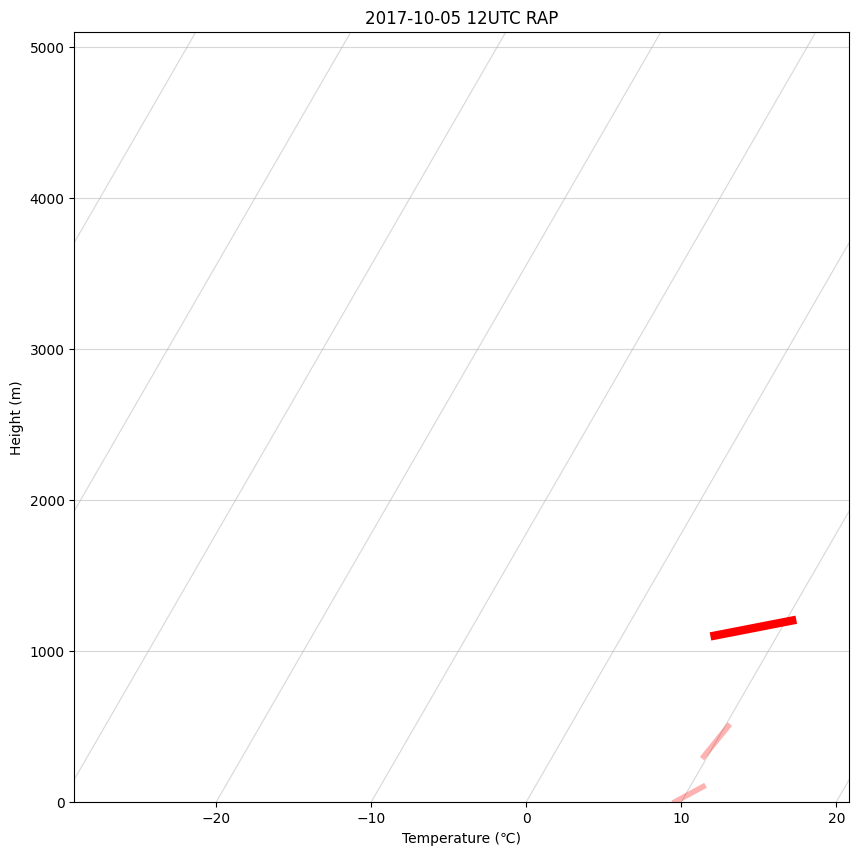

In [27]:
# Plot the inversions, highlighting the primary ivnersion

fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)


# Quickly make an inversion list using our organized data
inversions = []
for i in range(len(inversion_ranks)):
    inversions.append([[inversion_ranks['Starting Height'].iloc[i], inversion_ranks['Starting Temperature'].iloc[i]],
                       [inversion_ranks['Ending Height'].iloc[i], inversion_ranks['Ending Temperature'].iloc[i]]])

# Likewise the primary inversion
prime = []
for i in range(len(primary_inversion)):
    prime.append([[primary_inversion['Starting Height'].iloc[i], primary_inversion['Starting Temperature'].iloc[i]],
                  [primary_inversion['Ending Height'].iloc[i], primary_inversion['Ending Temperature'].iloc[i]]])

    
    
# Iterate over each line segment
for line in inversions:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=4, alpha=0.3) # We'll decrease the alpha channel of the inversions we
                                                               # don't care about so they don't stand out
        
# Plot the primary inversion
for line in prime:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=6, alpha=1)


# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC ' + station)
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Height (m)')

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

try:
    skew.set_xlim(np.max(df_standard['temperature']) - 40, np.max(df_standard['temperature']) + 10.)
    skew.set_ylim(0, 5100)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(0, 5100)

    # set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
                                               10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
                                               19000,
                                               20000]))
skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))
plt.show()

## And there you have it! Now the correct inversion is being shown

Just as a little side note, here's some code that normalizes ***everything***, even the chart

In [28]:
# Now we can resort and get the primary inversion
inversion_ranks_norm = inversion_ranks_norm.sort_values(by='Distance', ascending=False)
inversion_ranks_norm = inversion_ranks_norm.reset_index(drop=True)

primary_inversion = inversion_ranks_norm.head(1)

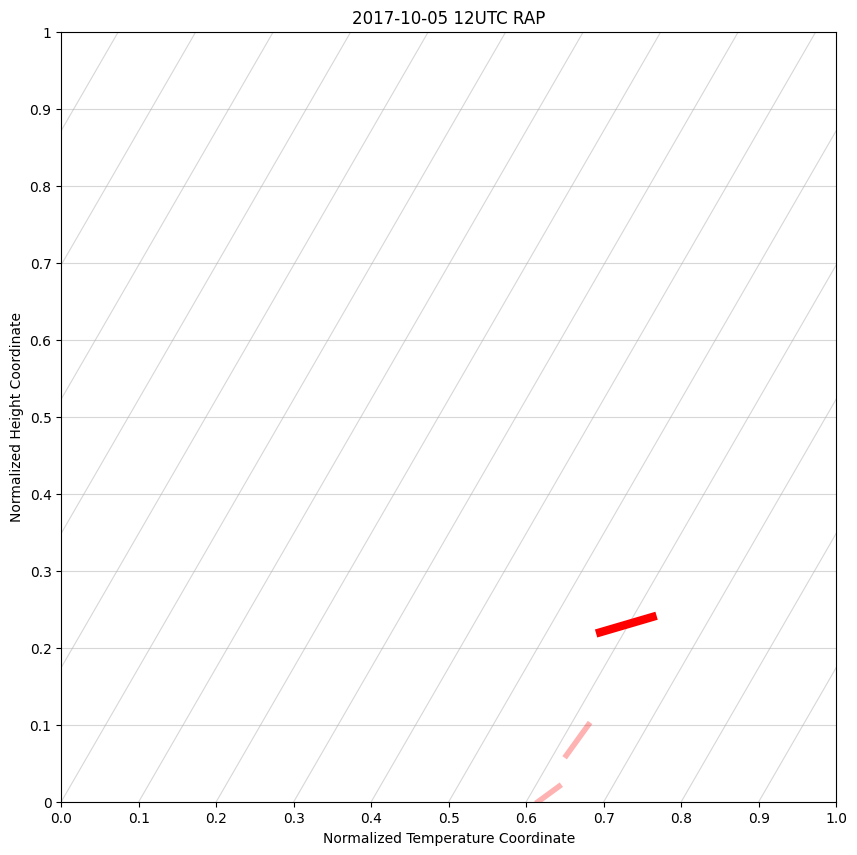

In [29]:
# Plot the inversions, highlighting the primary ivnersion

fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)


# Quickly make an inversion list using our organized data
inversions = []
for i in range(len(inversion_ranks_norm)):
    inversions.append([[inversion_ranks_norm['Starting Height'].iloc[i], inversion_ranks_norm['Starting Temperature'].iloc[i]],
                       [inversion_ranks_norm['Ending Height'].iloc[i], inversion_ranks_norm['Ending Temperature'].iloc[i]]])

# Likewise the primary inversion
prime = []
for i in range(len(primary_inversion)):
    prime.append([[primary_inversion['Starting Height'].iloc[i], primary_inversion['Starting Temperature'].iloc[i]],
                  [primary_inversion['Ending Height'].iloc[i], primary_inversion['Ending Temperature'].iloc[i]]])

    
    
# Iterate over each line segment
for line in inversions:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=4, alpha=0.3) # We'll decrease the alpha channel of the inversions we
                                                               # don't care about so they don't stand out
        
# Plot the primary inversion
for line in prime:
    
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    
    # Plot the line segment
    skew.plot(y_values, x_values, 'r', linewidth=6, alpha=1)


# Set some better labels than the default
skew.set_title(datetime.strftime(date, "%Y-%m-%d %H") + 'UTC ' + station)
skew.set_xlabel('Normalized Temperature Coordinate')
skew.set_ylabel('Normalized Height Coordinate')

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

skew.set_xlim(0, 1)
skew.set_ylim(0, 1)

    # set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
skew.xaxis.set_major_locator(plt.FixedLocator([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                              0.7, 0.8, 0.9, 1]))
plt.show()